In [111]:
import os
import pandas as pd
import numpy as np
import glob
import json
import nibabel 
import nilearn
from nilearn.plotting import plot_glass_brain
from nilearn.glm.second_level import SecondLevelModel
from nilearn.masking import intersect_masks
from nilearn.image import math_img

import matplotlib.pyplot as plt

In [ ]:
#TO DO: masks should be an intersection

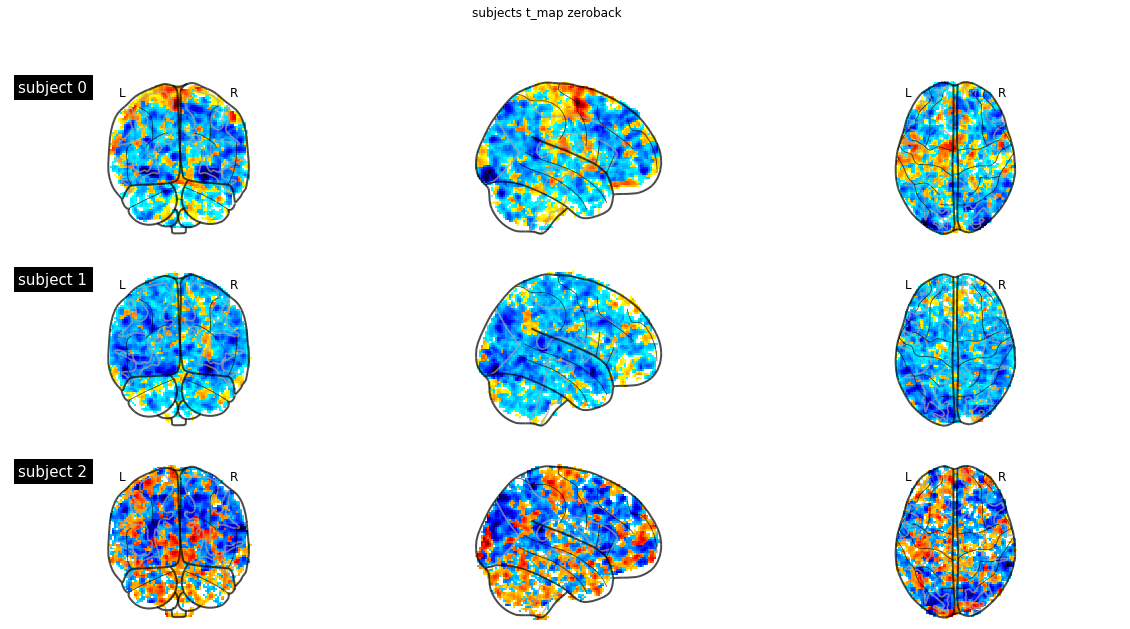

In [26]:
#plot individual subjects' tmaps

ses='1year'
task='nback'
#task='mid'
contrast='zeroback'
#contrast='RewCue-NeuCue'
space='MNI152NLin6Asym' #change if desired

stat_maps=[]

if task == 'nback':
    stat_maps=glob.glob(f'../../../derivatives/nilearn_small/first_level/sub-*/ses-{ses}/task-{task}/sub-*_ses-{ses}_task-{task}_rec-unco_run-1_contrast-{contrast}_stat.nii.gz')

if task == 'mid':
    stat_maps=glob.glob(f'../../../derivatives/nilearn_small/second_level/sub-*/ses-{ses}/task-{task}/sub-*_ses-{ses}_task-{task}_rec-unco_contrast-{contrast}_stat_fx.nii.gz')

    
#subjects = data['ext_vars']['participant_id'].tolist()
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20, 10))
#fig = plt.figure()
for cidx, tmap in enumerate(stat_maps):
    plot_glass_brain(
        tmap,
        colorbar=False,
        threshold=2.0,
        title=f'subject {cidx}',
        axes=axes[cidx],
        plot_abs=False,
        display_mode='ortho',
    )
fig.suptitle('subjects t_map zeroback')
plt.show()



In [17]:
#can trial group analysis with results in derivatives/nilearn_small for faster testing!! 
#nilearn_small only has first and second level results for sub-HC016, sub-MM028, sub-MM232, sub-MM248 

ses='1year'
task='nback'
contrast='twoback-zeroback'
space='MNI152NLin6Asym' #change if desired

#get individual effect size maps
effect_size_maps = glob.glob(f'../../../derivatives/nilearn/first_level/sub-*/ses-{ses}/task-{task}/sub-*_ses-{ses}_task-{task}_rec-unco_run-1_contrast-{contrast}_effect_size.nii.gz')

#create design matrix with 1 column of 1s and as many rows as there are subjects
design_matrix = pd.DataFrame(
    [1] * len(effect_size_maps),
    columns=['intercept'],
)




In [24]:
second_level_model = SecondLevelModel(smoothing_fwhm=None)
second_level_model = second_level_model.fit(
    effect_size_maps,
    design_matrix=design_matrix,
)


In [25]:
contrast_output = second_level_model.compute_contrast(output_type='all')

z_map = contrast_output['z_score']



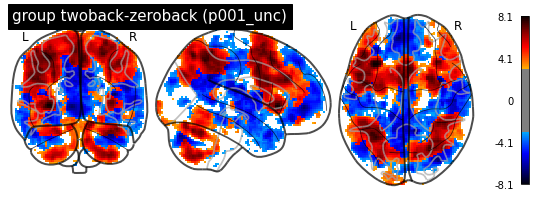

In [26]:
from scipy.stats import norm
from nilearn import plotting 

p_val = 0.001
p001_unc = norm.isf(p_val)
display = plot_glass_brain(
    z_map,
    threshold=p001_unc,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    title='group twoback-zeroback (p001_unc)',
)
plotting.show()

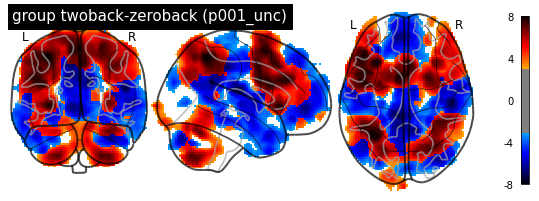

In [23]:
#FWHM =8 

from scipy.stats import norm
from nilearn import plotting 

p_val = 0.001
p001_unc = norm.isf(p_val)
display = plot_glass_brain(
    z_map,
    threshold=p001_unc,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    title='group twoback-zeroback (p001_unc)',
)
plotting.show()



In [ ]:
p001_unc

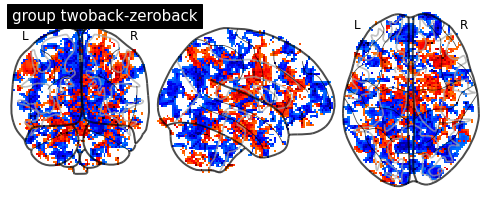

In [63]:
plot_glass_brain(
    z_map,
    colorbar=False,
    threshold=2.0,
    title='group twoback-zeroback',
    plot_abs=False,
    display_mode='ortho'
)

In [ ]:
#TO DO:

#add mask to group level
#do group for all
#plot time series of a single voxel to see if it aligns with HRF*regressor

In [ ]:
#group level model code for nback

In [6]:
#this is a group level model for a group mean at a particular session and for a particular group (HC or MM)
#written for nback task at the moment since explicitly taking from first_level directory
#TO DO: plot on MNI not on random brain

ses='1year'
task='nback'
group='MM'
contrast='twoback-zeroback'
space='MNI152NLin6Asym' #change if desired

#TO: loop through all contrasts, sessions, groups
#get individual effect size maps
effect_size_maps = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{group}*/ses-{ses}/task-{task}/sub-{group}*_ses-{ses}_task-{task}_rec-unco_run-1_contrast-{contrast}_effect_size.nii.gz')

#create design matrix with 1 column of 1s and as many rows as there are subjects
#TO DO: add Mean FD, sex, age columns (matched by subject)
design_matrix = pd.DataFrame(
    [1] * len(effect_size_maps),
    columns=['group_average'],
)


In [7]:
#grab masks needed
masks = glob.glob(f'../../../derivatives/ses-{ses}/sub-{group}*/ses-{ses}/func/sub-{group}*task-{task}*rec-unco*run-1_*{space}*brain_mask.nii.gz')

#make intersection of the masks
#threshold=1 corresponds to keeping the intersection of all masks, whereas threshold=0 is the union of all masks
mask = intersect_masks(masks, threshold=1, connected=True)



In [8]:
cache_loc = './nilearn_cache' #change if desired

second_level_model = SecondLevelModel(mask_img=mask, target_affine=None, target_shape=None, 
                                      smoothing_fwhm=None, memory=cache_loc, memory_level=1, 
                                      verbose=0, n_jobs=-2, minimize_memory=False)

second_level_model = second_level_model.fit(
    effect_size_maps,
    design_matrix=design_matrix,
)


________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x2ac8f36030d0>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.1s, 0.0min


In [10]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])

contrasts

{'group_average': array([1.])}

In [11]:
for contrast in contrasts:
    #setting stat_type to None means it will choose t stat or F stat, depending on whether the contrast is 1D or 2D
    contrast_output = second_level_model.compute_contrast(second_level_contrast=contrast, 
                                                      second_level_stat_type=None, output_type='all')

________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask([ '../../../derivatives/nilearn/first_level/sub-MM028/ses-1year/task-nback/sub-MM028_ses-1year_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '../../../derivatives/nilearn/first_level/sub-MM044/ses-1year/task-nback/sub-MM044_ses-1year_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '../../../derivatives/nilearn/first_level/sub-MM053/ses-1year/task-nback/sub-MM053_ses-1year_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '../../../derivatives/nilearn/first_level/sub-MM054/ses-1year/task-nback/sub-MM054_ses-1year_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '../../../derivatives/nile..., 
<nibabel.nifti1.Nifti1Image object at 0x2ac8f36030d0>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.934445, ..., -2.667226]), <nibabel.nifti1.Nifti1Image object at 0x2ac8f36030d0>)
___________________________________________________________unmask - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.974794, ..., -2.763643]), <nibabel.nifti1.Nifti1Image object at 0x2ac8f36030d0>)
___________________________________________________________unmask - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.973471, ..., 0.996176]), <nibabel.nifti1.Nifti1Image object at 0x2ac8f36030d0>)
___________________________________________________________unmask - 0.2s, 0.0min
____________

In [ ]:
#visualize nback results from above without multiple comparisons correction

In [12]:
z_map = contrast_output['z_score']

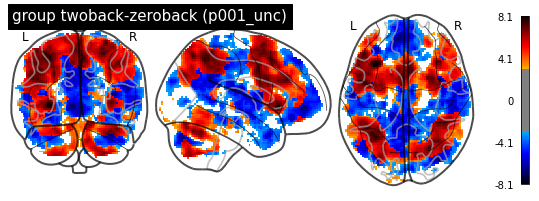

In [15]:
from scipy.stats import norm
from nilearn import plotting 

p_val = 0.001
p001_unc = norm.isf(p_val)
display = plot_glass_brain(
    z_map,
    threshold=p001_unc,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    title='group twoback-zeroback (p001_unc)',
)
plotting.show()

In [ ]:
#try out different ways to test for multiple comparisons

In [21]:
#Threshold the resulting map without multiple comparisons corrections
#abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels.

from nilearn.image import threshold_img
thresholded_map = threshold_img(
    z_map,
    threshold=3.29,
    cluster_threshold=10,
    two_sided=True,
)

In [22]:
#does same as cell above 
#This is equivalent to thresholding a z-statistic image with a false positive rate < .001, cluster size > 10 voxels.

from nilearn.glm import threshold_stats_img
thresholded_map1, threshold1 = threshold_stats_img(
    z_map,
    alpha=.001,
    height_control='fpr',
    cluster_threshold=10,
    two_sided=True,
)

In [24]:
#Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.


thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

The FDR=.05 threshold is 2.41


In [25]:
#Now use FWER <.05 (Family-Wise Error Rate) and no cluster-level threshold. 
#As the data has not been intensively smoothed, we can use a simple Bonferroni correction.

thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)

The p<.05 Bonferroni-corrected threshold is 5.16


In [26]:
#visualize the results from the different multiple comparisons corrections

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


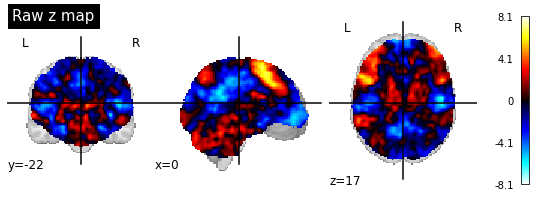

In [27]:
#plot unthresholded map

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map')

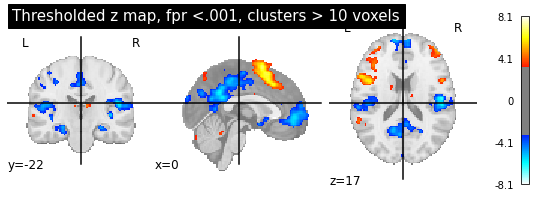

In [28]:
#plot the p<.001 uncorrected-thresholded map (with only clusters > 10 voxels).

plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='Thresholded z map, fpr <.001, clusters > 10 voxels')

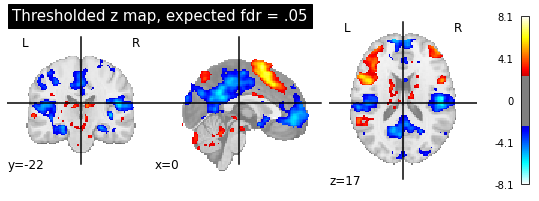

In [29]:
#Third, the fdr-thresholded map.

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='Thresholded z map, expected fdr = .05',
                       threshold=threshold2)

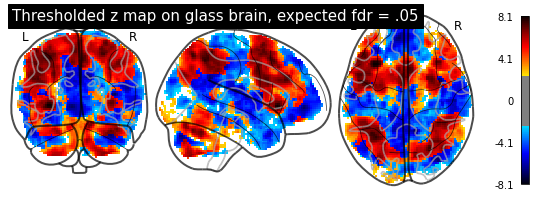

In [31]:
display = plot_glass_brain(
    thresholded_map2,
    threshold=threshold2,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    title='Thresholded z map on glass brain, expected fdr = .05',
)
plotting.show()

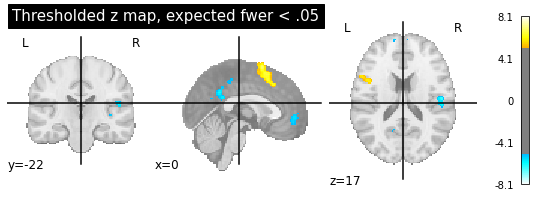

In [30]:
#Fourth, the Bonferroni-thresholded map.

plotting.plot_stat_map(thresholded_map3, cut_coords=display.cut_coords,
                       title='Thresholded z map, expected fwer < .05',
                       threshold=threshold3)

In [ ]:
#plotting on surface

In [33]:
from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

In [34]:
from nilearn import surface

texture = surface.vol_to_surf(z_map, fsaverage.pial_right)


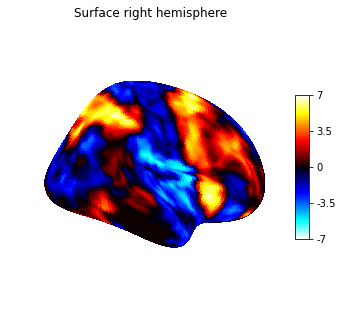

In [36]:
fig = plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture, hemi='right',
    title='Surface right hemisphere', colorbar=True,
    threshold=None, bg_map=fsaverage.sulc_right
)
fig.show()


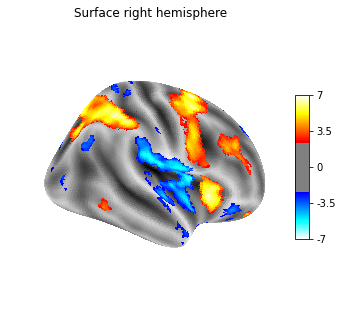

In [37]:
texture = surface.vol_to_surf(thresholded_map2, fsaverage.pial_right)

fig = plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture, hemi='right',
    title='Surface right hemisphere', colorbar=True,
    threshold=threshold2, bg_map=fsaverage.sulc_right
)
fig.show()


In [63]:
#attempt group difference model for control vs. MM at baseline 
#written for nback task at the moment since explicitly taking from first_level directory

groups=['MM','HC']
ses='baseline'
task='nback'
contrast='twoback-zeroback'
space='MNI152NLin6Asym' #change if desired

#TO: loop through all contrasts
#get individual effect size maps
effect_size_maps=[]
group_sizes=[]
for group in groups:
    effect_size_maps_by_group = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{group}*/ses-{ses}/task-{task}/sub-{group}*_ses-{ses}_task-{task}_rec-unco_run-1_contrast-{contrast}_effect_size.nii.gz')
    effect_size_maps += effect_size_maps_by_group
    group_sizes.append(len(effect_size_maps_by_group))

#create design matrix with 1 column of 1s and as many rows as there are subjects
#TO DO: add Mean FD, sex, age columns (matched by subject)
df1=pd.DataFrame({f'{groups[0]}':np.ones(group_sizes[0]),f'{groups[1]}':np.zeros(group_sizes[0])})
df2=pd.DataFrame({f'{groups[0]}':np.zeros(group_sizes[1]),f'{groups[1]}':np.ones(group_sizes[1])})
design_matrix = pd.concat([df1, df2], ignore_index=True,axis=0)  



In [64]:
#grab masks needed
masks = glob.glob(f'../../../derivatives/ses-{ses}/sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-1_*{space}*brain_mask.nii.gz')

#make intersection of the masks
#threshold=1 corresponds to keeping the intersection of all masks, whereas threshold=0 is the union of all masks
mask = intersect_masks(masks, threshold=1, connected=True)



In [65]:
cache_loc = './nilearn_cache' #change if desired

second_level_model = SecondLevelModel(mask_img=mask, target_affine=None, target_shape=None, 
                                      smoothing_fwhm=None, memory=cache_loc, memory_level=1, 
                                      verbose=0, n_jobs=-2, minimize_memory=False)

second_level_model = second_level_model.fit(
    effect_size_maps,
    design_matrix=design_matrix,
)

________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.0s, 0.0min


In [67]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])
contrasts[f'{groups[0]}-{groups[1]}']=contrasts[f'{groups[0]}']-contrasts[f'{groups[1]}']
contrasts

{'MM': array([1., 0.]), 'HC': array([0., 1.]), 'MM-HC': array([ 1., -1.])}

In [68]:
contrast_output=[]

for contrast in contrasts:
    #setting stat_type to None means it will choose t stat or F stat, depending on whether the contrast is 1D or 2D
    contrast_output.append(second_level_model.compute_contrast(second_level_contrast=contrast, 
                                                      second_level_stat_type=None, output_type='all'))

________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask([ '../../../derivatives/nilearn/first_level/sub-MM104/ses-baseline/task-nback/sub-MM104_ses-baseline_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '../../../derivatives/nilearn/first_level/sub-MM127/ses-baseline/task-nback/sub-MM127_ses-baseline_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '../../../derivatives/nilearn/first_level/sub-MM129/ses-baseline/task-nback/sub-MM129_ses-baseline_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '../../../derivatives/nilearn/first_level/sub-MM131/ses-baseline/task-nback/sub-MM131_ses-baseline_task-nback_rec-unco_run-1_contrast-twoback-zeroback_effect_size.nii.gz',
  '...., 
<nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.400379, ..., -2.759673]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.411866, ..., -2.826458]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.0807  , ..., 0.997107]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.028275, ..., -1.531769]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.028353, ..., -1.545983]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.488721, ..., 0.93721 ]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.4s, 0.0min
____________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.801589, ..., -0.404602]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.805222, ..., -0.405899]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.211395, ..., 0.657115]), <nibabel.nifti1.Nifti1Image object at 0x2ac90ec7ad90>)
___________________________________________________________unmask - 0.2s, 0.0min
____________

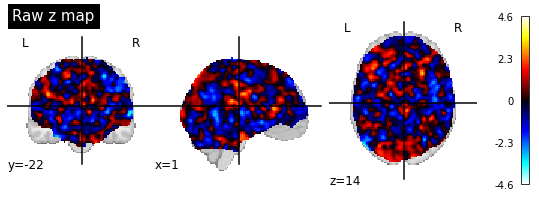

In [92]:
#get MM-HC at baseline z_map

z_map = contrast_output[2]['z_score']
display = plotting.plot_stat_map(z_map, title='Raw z map')

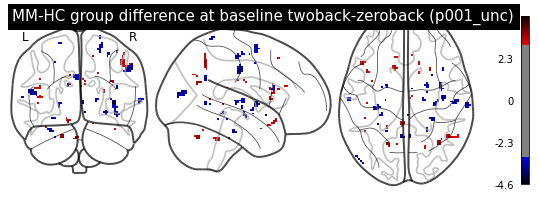

In [93]:
#uncorrected plot

from scipy.stats import norm
from nilearn import plotting 

p_val = 0.001
p001_unc = norm.isf(p_val)
display = plot_glass_brain(
    z_map,
    threshold=p001_unc,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    title='MM-HC group difference at baseline twoback-zeroback (p001_unc)',
)
plotting.show()

In [94]:
#Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.

thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

The FDR=.05 threshold is inf


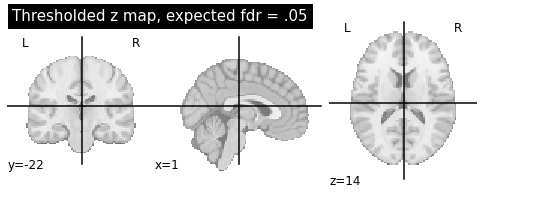

In [95]:
#Third, the fdr-thresholded map.

plotting.plot_stat_map(thresholded_map2, cut_coords=[1,-22,14],
                       title='Thresholded z map, expected fdr = .05',
                       threshold=threshold2)

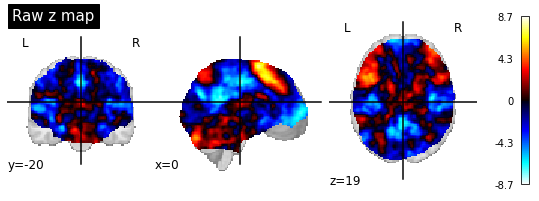

In [96]:
#MM baseline group mean z_map

z_map = contrast_output[0]['z_score']
display = plotting.plot_stat_map(z_map, title='Raw z map')

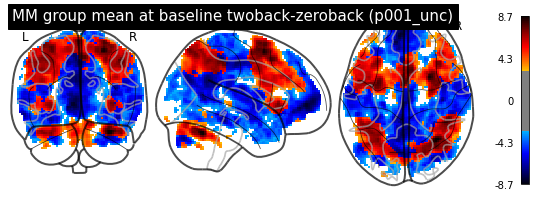

In [97]:
#uncorrected plot

from scipy.stats import norm
from nilearn import plotting 

p_val = 0.001
p001_unc = norm.isf(p_val)
display = plot_glass_brain(
    z_map,
    threshold=p001_unc,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    title='MM group mean at baseline twoback-zeroback (p001_unc)',
)
plotting.show()

In [98]:
#Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.

thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

The FDR=.05 threshold is 2.35


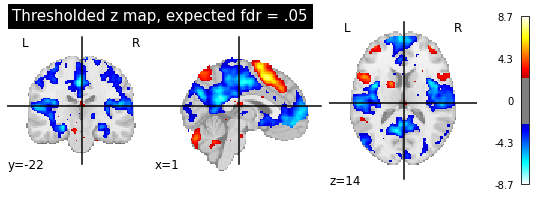

In [99]:
#Third, the fdr-thresholded map.

plotting.plot_stat_map(thresholded_map2, cut_coords=[1,-22,14],
                       title='Thresholded z map, expected fdr = .05',
                       threshold=threshold2)

In [116]:
#MM 1year - MM baseline group difference using paired test
#written for nback task at the moment since explicitly taking from first_level directory


sessions=['1year','baseline']
task='nback'
group='MM'
contrast='twoback-zeroback'
space='MNI152NLin6Asym' #change if desired

#TO: loop through all contrasts
#get individual effect size maps by subjects
effect_size_maps_by_ses = [] #list of two dictionaries, one per ses, both with subjects as keys and their effect size paths as values
for ses in sessions:
    effect_size_maps = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{group}*/ses-{ses}/task-{task}/sub-{group}*_ses-{ses}_task-{task}_rec-unco_run-1_contrast-{contrast}_effect_size.nii.gz')
    effect_size_by_subj_dict = {}
    for path in effect_size_maps:
        subj = path.split(f'/first_level/sub-')[1].split('/ses-')[0]
        effect_size_by_subj_dict[subj] = path
    effect_size_maps_by_ses.append(effect_size_by_subj_dict)
    
#find subjects with both baseline and 1year scans
subjs_with_both_ses = list(set(effect_size_maps_by_ses[0].keys()).intersection(set(effect_size_maps_by_ses[1].keys())))

#subtract baseline from 1year scans
#save as list of nii effect size maps
effect_size_maps=[]
for sub in subjs_with_both_ses:
    effect_size_map_0 = nibabel.load(effect_size_maps_by_ses[0][sub])
    effect_size_map_1 = nibabel.load(effect_size_maps_by_ses[1][sub])
    diff_img = math_img("img0 - img1", img0=effect_size_map_0, img1=effect_size_map_1)
    effect_size_maps.append(diff_img)
    

#create design matrix with 1 column of 1s and as many rows as there are subjects
#TO DO: add Mean FD, sex, age columns (matched by subject)
design_matrix = pd.DataFrame(
    [1] * len(effect_size_maps),
    columns=['group_average'],
)


In [117]:
#grab masks needed
masks = glob.glob(f'../../../derivatives/ses-*/sub-{group}*/ses-*/func/sub-{group}*task-{task}*rec-unco*run-1_*{space}*brain_mask.nii.gz')

#make intersection of the masks
#threshold=1 corresponds to keeping the intersection of all masks, whereas threshold=0 is the union of all masks
mask = intersect_masks(masks, threshold=1, connected=True)



In [119]:
cache_loc = './nilearn_cache' #change if desired

second_level_model = SecondLevelModel(mask_img=mask, target_affine=None, target_shape=None, 
                                      smoothing_fwhm=None, memory=cache_loc, memory_level=1, 
                                      verbose=0, n_jobs=-2, minimize_memory=False)

second_level_model = second_level_model.fit(
    effect_size_maps,
    design_matrix=design_matrix,
)


________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x2ac912b63d00>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.0s, 0.0min


In [120]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])

contrasts

{'group_average': array([1.])}

In [122]:
contrast = contrasts['group_average']
contrast_output = second_level_model.compute_contrast(second_level_contrast=contrast, 
                                                      second_level_stat_type=None, output_type='all')

________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask([ <nibabel.nifti1.Nifti1Image object at 0x2ac91289bb20>,
  <nibabel.nifti..., 
<nibabel.nifti1.Nifti1Image object at 0x2ac912b63d00>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, memory_level=1, memory=Memory(location=./nilearn_cache/joblib), verbose=0, confounds=None, sample_mask=None, copy=True, dtype=None)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


__________________________________________________filter_and_mask - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[2.011811, ..., 0.767774],
       ...,
       [1.349836, ..., 0.75328 ]]), array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]]), n_jobs=-2, noise_model='ols')
__________________________________________________________run_glm - 0.8s, 0.0min
___________________________________________

In [123]:
z_map = contrast_output['z_score']

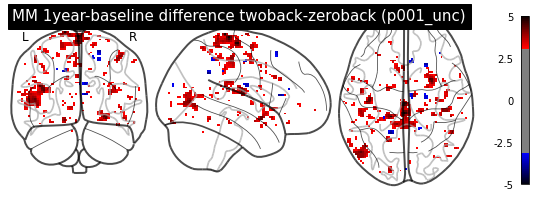

In [126]:
from scipy.stats import norm
from nilearn import plotting 

p_val = 0.001
p001_unc = norm.isf(p_val)
display = plot_glass_brain(
    z_map,
    threshold=p001_unc,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    title='MM 1year-baseline difference twoback-zeroback (p001_unc)',
)
plotting.show()

In [127]:
#Threshold the resulting map without multiple comparisons corrections
#abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels.

from nilearn.image import threshold_img
thresholded_map = threshold_img(
    z_map,
    threshold=3.29,
    cluster_threshold=10,
    two_sided=True,
)

In [128]:
#Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.


thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

The FDR=.05 threshold is inf


In [129]:
#Now use FWER <.05 (Family-Wise Error Rate) and no cluster-level threshold. 
#As the data has not been intensively smoothed, we can use a simple Bonferroni correction.

thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)

The p<.05 Bonferroni-corrected threshold is 5.15


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.95746785453565. But, you have given threshold=5.148533727718658 
  warnings.warn("The given float value must not exceed {0}. "


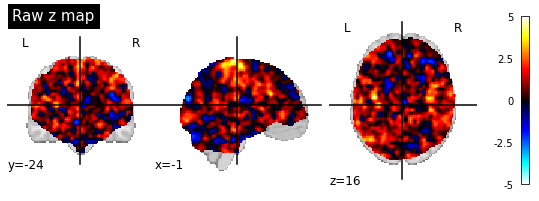

In [130]:
#plot unthresholded map

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map')

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


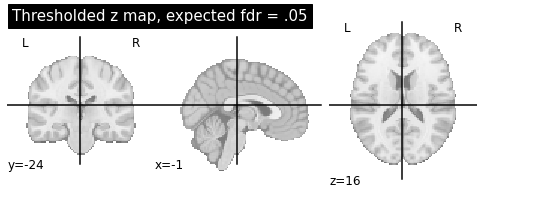

In [131]:
#Third, the fdr-thresholded map.

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='Thresholded z map, expected fdr = .05',
                       threshold=threshold2)